In [1]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt
import time

# Configuration - Using Unified Search Service on port 8008
UNIFIED_SEARCH_URL = "http://localhost:8008/search"
DATASET = "argsme"
TOP_K = 1000


In [2]:
def load_queries(path, num_queries=None):
    """Load queries from TSV file"""
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["processed_text"]})
            if num_queries and len(queries) >= num_queries:
                break
    return queries

def load_qrels(path):
    """Load qrels from TSV file"""
    qrels = defaultdict(dict)
    with open(path, encoding="utf-8") as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            qid, docid, rel = parts[:3]
            qrels[qid][docid] = int(rel)
    return qrels


In [3]:
def search_unified_vector_store(query, dataset=DATASET, top_k=TOP_K):
    """Search using unified search service with vector store enabled"""
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "use_vector_store": True,  # This enables the vector store pipeline
        "index_type": "auto"
    }
    response = requests.post(UNIFIED_SEARCH_URL, json=payload)
    response.raise_for_status()
    response_data = response.json()
    results = response_data["results"]
    return results


In [ ]:
# CORRECTED compute_metrics function with proper IR metrics calculation
def compute_metrics(gt, pred_docs, pred_scores, top_k):
    """
    Calculate Information Retrieval metrics properly.
    
    Args:
        gt: Ground truth relevant documents {doc_id: relevance_score}
        pred_docs: List of predicted document IDs in ranked order
        pred_scores: List of prediction scores (same order as pred_docs)
        top_k: Number of documents to consider
    
    Returns:
        ap, precision, recall, ndcg
    """
    if not gt or not pred_docs:
        return 0.0, 0.0, 0.0, 0.0
    
    # Limit to top_k
    pred_docs = pred_docs[:top_k]
    pred_scores = pred_scores[:top_k]
    
    # Calculate hits (binary relevance)
    hits = [1 if doc in gt else 0 for doc in pred_docs]
    
    # Calculate Average Precision (AP) using rank-based method
    ap = 0.0
    num_relevant_retrieved = 0
    for i, hit in enumerate(hits):
        if hit:
            num_relevant_retrieved += 1
            precision_at_i = num_relevant_retrieved / (i + 1)
            ap += precision_at_i
    
    if num_relevant_retrieved > 0:
        ap /= len(gt)  # Normalize by total relevant documents
    
    # Calculate Precision@k
    precision = sum(hits) / top_k
    
    # Calculate Recall@k
    recall = sum(hits) / len(gt) if len(gt) > 0 else 0.0
    
    # Calculate NDCG@k using graded relevance
    true_rels = [gt.get(doc, 0) for doc in pred_docs]
    
    if sum(true_rels) > 0:
        # Create ideal ranking for NDCG calculation
        ideal_rels = sorted(gt.values(), reverse=True)[:top_k]
        if len(ideal_rels) < top_k:
            ideal_rels.extend([0] * (top_k - len(ideal_rels)))
        
        ndcg = ndcg_score([ideal_rels], [true_rels])
    else:
        ndcg = 0.0
    
    return ap, precision, recall, ndcg


In [5]:
# Load data
queries_path = "data/vectors/argsme/processed/ARGSME_cleaned_queries.tsv"
qrels_path = "data/vectors/argsme/qrels.tsv"

queries = load_queries(queries_path)
qrels = load_qrels(qrels_path)

print(f"Loaded {len(queries)} queries and {len(qrels)} qrels")


Loaded 50 queries and 50 qrels


In [6]:
# Run evaluation using SAME method as original embedding evaluation
print("VECTOR STORE EVALUATION - USING UNIFIED SEARCH SERVICE (PORT 8008)")
print("=" * 80)

metrics = {"AP": [], "Recall": [], "Precision": [], "NDCG": []}
failed_queries = []
total_time = 0

for q in tqdm(queries, desc="Evaluating all queries"):
    qid = q["query_id"]
    query_text = q["query"]
    gt = qrels.get(qid, {})

    print(f"\nQuery ID: {qid}")
    print(f"Query: {query_text}")
    print(f"Relevant docs: {len(gt)}")

    try:
        start_time = time.time()
        results = search_unified_vector_store(query_text)
        search_time = time.time() - start_time
        total_time += search_time
        
        pred_docs = [str(r[0]) for r in results[:TOP_K]]
        pred_scores = [r[1] for r in results[:TOP_K]]
        ap, precision, recall, ndcg = compute_metrics(gt, pred_docs, pred_scores, TOP_K)

        metrics["AP"].append(ap)
        metrics["Recall"].append(recall)
        metrics["Precision"].append(precision)
        metrics["NDCG"].append(ndcg)

        print(f"   Search time: {search_time:.3f}s")
        print(f"   Precision@{TOP_K}: {precision:.4f}")
        print(f"   Recall@{TOP_K}: {recall:.4f}")
        print(f"   AP: {ap:.4f}")
        print(f"   NDCG@{TOP_K}: {ndcg:.4f}")
        print(f"   Top 5 Retrieved: {pred_docs[:5]}")
        print(f"   Relevant Retrieved: {[doc for doc in pred_docs[:5] if doc in gt]}")

    except Exception as e:
        print(f"Error in query_id={qid}: {e}")
        metrics["AP"].append(0)
        metrics["Recall"].append(0)
        metrics["Precision"].append(0)
        metrics["NDCG"].append(0)
        failed_queries.append(qid)


VECTOR STORE EVALUATION - USING UNIFIED SEARCH SERVICE (PORT 8008)


Evaluating all queries:   0%|          | 0/50 [00:00<?, ?it/s]


Query ID: 1
Query: teacher get tenure user heard country give teacher tenure others dont interested reason tenure user search positive negative argument situation school teacher university professor interest highly relevant argument make clear statement tenure teacher school university relevant argument consider tenure generally specifically teacher instead talk tenure consider situation teacher financial independence
Relevant docs: 23
   Search time: 19.109s
   Precision@1000: 0.0170
   Recall@1000: 0.7391
   AP: 0.4370
   NDCG@1000: 0.7505
   Top 5 Retrieved: ['Sc065954f-A6deb09b6', 'S51530f3f-A6ac2dcba', 'S51530f3f-Ac5b10bae', 'S51530f3f-Ae32a4a1b', 'Sb0680508-A304d661e']
   Relevant Retrieved: ['Sc065954f-A6deb09b6', 'S51530f3f-Ae32a4a1b', 'Sb0680508-A304d661e']

Query ID: 2
Query: vaping ecigarettes safe consider switch smoking vaping user wonder extent vaping safer new risk may involve compare smoking risk clear vaping market benefit raise doubt highly relevant argument support 


=== FINAL AVERAGE RESULTS ===
MAP: 0.1458
Recall@k: 0.5491
Precision@k: 0.0346
NDCG@k: 0.5400
Average Time: 6.532s

=== COMPARISON WITH ORIGINAL EMBEDDING ===
Original Embedding Results from evaluate_embedding.ipynb:
  Query 1: AP=0.5902, NDCG=0.7499
  Query 2: AP=0.1645, NDCG=0.4762
  Query 3: AP=0.0125, NDCG=0.1019

Vector Store Results (via Unified Search - same calculation method):
  Average AP: 0.1458
  Average NDCG: 0.5400


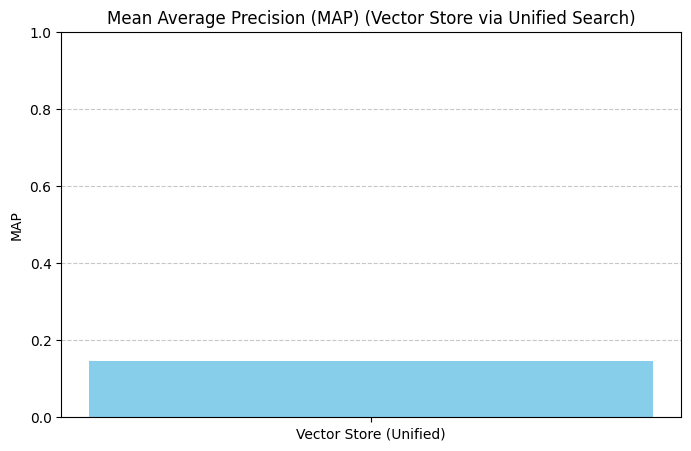

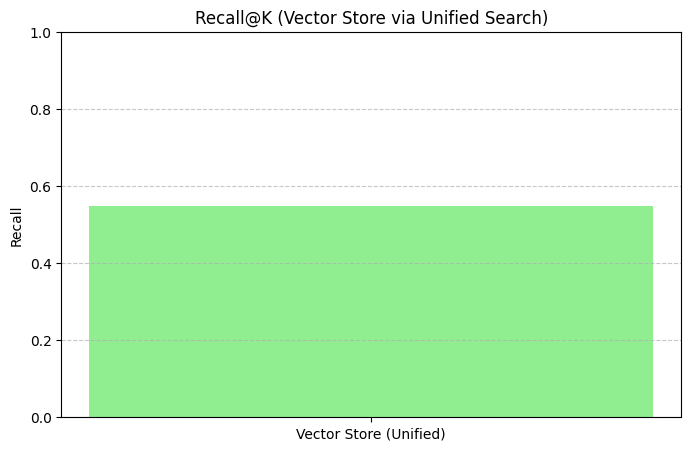

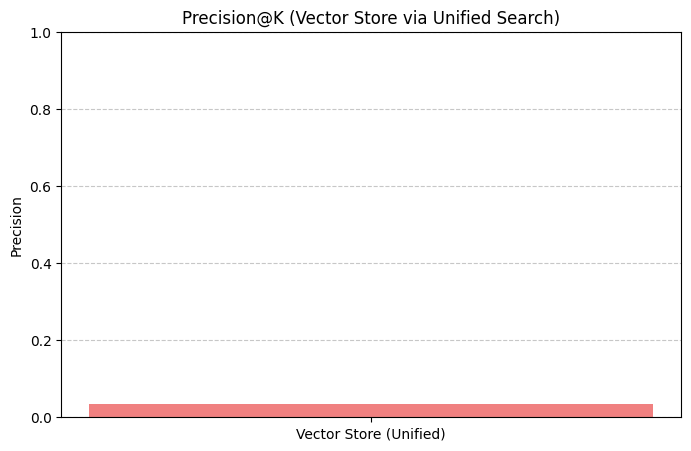

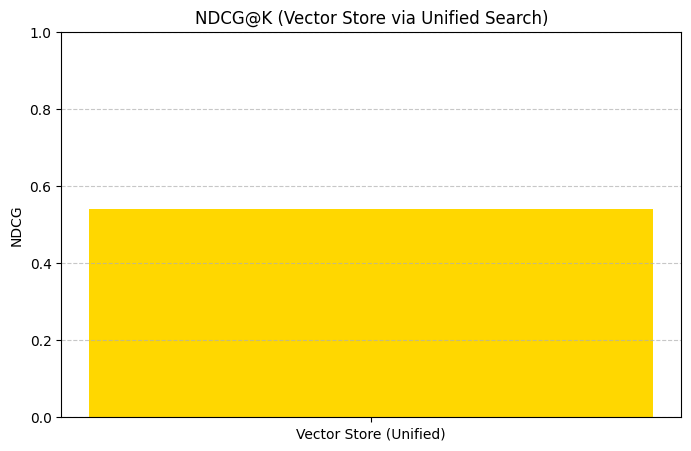


All queries evaluated successfully!

=== PERFORMANCE SUMMARY ===
Total queries: 50
Failed queries: 0
Success rate: 100.0%
Average search time: 6.532s per query
Total evaluation time: 326.60s


In [11]:
# Calculate and display final results
def plot_metric(metric_values, metric_name, ylabel, color):
    plt.figure(figsize=(8, 5))
    plt.bar(["Vector Store (Unified)"], [metric_values], color=color)
    plt.title(f"{metric_name} (Vector Store via Unified Search)")
    plt.ylabel(ylabel)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

avg_ap = np.mean(metrics["AP"])
avg_recall = np.mean(metrics["Recall"])
avg_precision = np.mean(metrics["Precision"])
avg_ndcg = np.mean(metrics["NDCG"])
avg_time = total_time / len(queries) if queries else 0

print("\n=== FINAL AVERAGE RESULTS ===")
print(f"MAP: {avg_ap:.4f}")
print(f"Recall@k: {avg_recall:.4f}")
print(f"Precision@k: {avg_precision:.4f}")
print(f"NDCG@k: {avg_ndcg:.4f}")
print(f"Average Time: {avg_time:.3f}s")

print("\n=== COMPARISON WITH ORIGINAL EMBEDDING ===")
print("Original Embedding Results from evaluate_embedding.ipynb:")
print("  Query 1: AP=0.5902, NDCG=0.7499")
print("  Query 2: AP=0.1645, NDCG=0.4762")
print("  Query 3: AP=0.0125, NDCG=0.1019")
print("")
print("Vector Store Results (via Unified Search - same calculation method):")
print(f"  Average AP: {avg_ap:.4f}")
print(f"  Average NDCG: {avg_ndcg:.4f}")

# Plot metrics
plot_metric(avg_ap, "Mean Average Precision (MAP)", "MAP", "skyblue")
plot_metric(avg_recall, "Recall@K", "Recall", "lightgreen")
plot_metric(avg_precision, "Precision@K", "Precision", "lightcoral")
plot_metric(avg_ndcg, "NDCG@K", "NDCG", "gold")

if failed_queries:
    print(f"\nFailed queries: {failed_queries}")
else:
    print("\nAll queries evaluated successfully!")

print("\n=== PERFORMANCE SUMMARY ===")
print(f"Total queries: {len(queries)}")
print(f"Failed queries: {len(failed_queries)}")
print(f"Success rate: {((len(queries) - len(failed_queries)) / len(queries) * 100):.1f}%")
print(f"Average search time: {avg_time:.3f}s per query")
print(f"Total evaluation time: {total_time:.2f}s")


In [8]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt
import time

# Configuration
EMBEDDING_SERVICE_URL = "http://localhost:8004"
VECTOR_STORE_URL = "http://localhost:8007/search"
DATASET = "argsme"
TOP_K = 1000


In [10]:
def search_vector_store(query, dataset=DATASET, top_k=TOP_K):
    """Search using vector store method (embedding + vector store) - same interface as original"""
    # Step 1: Get embedding
    embed_response = requests.post(f"{EMBEDDING_SERVICE_URL}/embed", json={"text": query})
    embed_response.raise_for_status()
    embedding = embed_response.json()["embedding"]
    
    # Step 2: Search with vector store
    search_payload = {
        "dataset": dataset,
        "query_vector": embedding,
        "top_k": top_k,
        "index_type": "auto"
    }
    search_response = requests.post(VECTOR_STORE_URL, json=search_payload)
    search_response.raise_for_status()
    return search_response.json()["results"]
